# Geospatial Analysis Techniques

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
from scipy import stats
import os
from pathlib import Path
import importlib
import inspect
import random
import geopandas
import matplotlib as mpl


# Getis Ord Local G

In [16]:
def calc_gi_kth_updated(data_vector,adj_matrix):
    GiD = []
    Wi = []
    EGi = []
    VarG = []
    if type(adj_matrix) != type([]):
        adj_matrix = adj_matrix.values.tolist()
    assert len(data_vector) > 1, 'Data vector dimension must be larger than 1'
    assert len(data_vector) == len(adj_matrix), 'Data and Adjacency dimension mismatch'
    assert len(data_vector) == len(adj_matrix[0]), 'Data and Adjacency dimension mismatch'
    for i in range(len(data_vector)):
        n = len(data_vector)
        adj_vector = adj_matrix[i]
        xjwi = [adj_vector[j] * data_vector[j] if j!=i else 0 for j in range(n)]
        xj = [data_vector[j] if j!=i else 0 for j in range(n)]
        GiD.append(sum(xjwi)/sum(xj))
        Wi.append(sum(adj_vector))
        #print(GiD[-1])
        EGi.append(Wi[-1] / (n-1))
        yi1 = sum(xj)/(n-1)
        yi2 = sum([i**2 for i in xj])/(n-1) - yi1**2
        VG = (Wi[-1]*(n-1-Wi[-1])*yi2) / (((n-1)**2) * (n-2) * (yi1**2))
        VarG.append(VG)
        #print(GiD[-1],EGi[-1],VG,  (GiD[-1]-EGi[-1])/(VG**0.5))
    Z = [(GiD[i]-EGi[i]) / (VarG[i]**0.5) for i in range(len(data_vector))]
    return(GiD,Wi,EGi,VarG,Z)

# Anselin's Moran's I Statistic

Local Indicators of Spatial Autocorrelation use Z scores in place of direct data. 

In [17]:
def calc_local_i(z_values, adj):
    I = []
    EI = []
    Var = []
    Z_results = []
    n = len(z_values)
    m2 = 1 # because z normalization is used; otherwise m2 = sum([j**2/n for j in z_values])
    m4 = sum([i**4/n for i in z_values])
    b2 = m4/m2**2
    for i in range(len(z_values)):
        adj_vector = adj[i]
        adj_vector[i] = 0 # explicitly verifying w_{ii} == 0
        z = z_values[i]
        local_i =  (z/m2) *sum([adj_vector[j]*z_values[j] for j in range(n)])
        I.append(local_i)
        wi = sum(adj_vector)
        ei = -wi/(n-1)
        EI.append(ei)
        wi2 = sum([j**2 for j in adj_vector])
        _2wikh = (wi*(wi-1))/2 # n choose 2
        var_i = (wi2*(n-b2))/(n-1) + (_2wikh*(2*b2-n))/((n-1)*(n-2)) - (wi**2)/((n-1)**2)
        Var.append(var_i)
        z_calc = (local_i - ei) / var_i**0.5
        Z_results.append(z_calc)
    return(I, EI, Var, Z_results)

# Geospatial analysis on CBSA data

#### Functions

In [18]:
def filter_dists(dist_df,array,col):
    df_unstacked = dist_df.set_index(col).unstack().reset_index(name='value')
    df_unstacked.columns = [col,'GEOID_2','DISTANCE']
    df_unstacked = df_unstacked[df_unstacked[col].isin(filter_list)]
    df_unstacked = df_unstacked[df_unstacked['GEOID_2'].isin(filter_list)]
    df_restacked = pd.pivot_table(df_unstacked, values = 'DISTANCE',index=col,columns='GEOID_2').reset_index()
    df_restacked.columns = df_restacked.columns.get_level_values(0)
    df_restacked.columns = [col for col in df_restacked.columns.values]
    return df_restacked

In [19]:
def knn_adj_matrix(adj,k):
    adj_matrix = []
    if type(adj) != type([]):
        adj = adj.values.tolist()
    for row in adj:
        threshold = sorted(list(row))[k-1]
        new_row = [1 if i <= threshold else 0 for i in row]
        adj_matrix.append(new_row)
    return adj_matrix

    
def dist_adj_matrix():
    pass

In [20]:
def z_score_array(values):
    value_mean = sum(values) / len(values)
    value_stdev = (sum([(i-value_mean)**2 for i in values])/len(values))**0.5
    z_values = [(i-value_mean) / value_stdev for i in values]
    return z_values

#### Data Import and Preparation

In [21]:
#my_path = Path('C:/Users/Jericho/Documents/csi_research/family-geog/data/clean/cbsa')
my_path = Path('/Users/jericho/Documents/csi/family-geog/data/clean/cbsa')
os.chdir(my_path)
cbsa_summary_df = pd.read_csv('cbsa_summary.csv')

#my_path = Path('C:/Users/Jericho/Documents/csi_research/family-geog/data/clean/')
my_path = Path('/Users/jericho/Documents/csi/family-geog/data/clean/')
os.chdir(my_path)
cbsa_dists = pd.read_csv('cbsa_dist_matrix.csv')


#data_path = Path('C:/Users/Jericho/Documents/csi_research/Dissertation')
data_path = Path('/Users/jericho/Documents/csi/csi-research/Data')

os.chdir(data_path)

csa_latlong = pd.read_csv('csa_latlong.csv')
cbsa_latlong = pd.read_csv('2021_Gaz_cbsa_national.txt',sep='\t')
cbsa_latlong.columns = ['CSAFP', 'GEOID', 'NAME', 'CBSA_TYPE', 'ALAND', 'AWATER', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT','INTPTLONG']
cbsa_latlong = cbsa_latlong[['CSAFP', 'GEOID', 'NAME','INTPTLAT','INTPTLONG']]  

cbsa_regions = pd.read_csv('cbsa-county-region-crosswalk.csv')

cbsa_summary_df.columns = ['GEO'] + cbsa_summary_df.columns.tolist()[1:]

temp_cols = cbsa_dists.columns.tolist()
for i in range(len(temp_cols)):
    try:
        temp_cols[i] = int(temp_cols[i])
    except:
        pass
cbsa_dists.columns = temp_cols

In [22]:
cbsa_regions_trunc = cbsa_regions[['CBSA Code','Region','Sub Region']]
cbsa_regions_trunc = cbsa_regions_trunc.drop_duplicates()
cbsa_dists = cbsa_dists.replace(0,np.inf)
filter_list = cbsa_summary_df['GEO'].tolist()
cbsa_dists_filtered = filter_dists(cbsa_dists,filter_list,'GEOID')
cbsa_dists_filtered = cbsa_dists_filtered.set_index('GEOID')
cbsa_dists_filtered.head(3)

10180    10420    10580    10740    10900    11100    11460    11540  \
GEOID                                                                           
10180      inf  1149.75  1525.84   416.89  1409.35   235.68  1089.70  1040.18   
10420  1149.75      inf   378.19  1358.86   293.62  1137.20   145.65   407.23   
10580  1525.84   378.19      inf  1732.89   162.97  1514.37   476.35   689.23   

        11700   12020  ...    48140    48620    48660    48700    49020  \
GEOID                  ...                                                
10180  955.33  915.81  ...  1050.44   399.75   117.37  1346.42  1229.62   
10420  411.41  534.45  ...   491.60   840.47  1037.61   210.33   198.53   
10580  686.51  800.90  ...   759.05  1216.23  1414.69   184.45   340.68   

         49180    49340    49620    49660    49740  
GEOID                                               
10180  1083.27  1603.02  1327.56  1186.79   788.86  
10420   374.61   464.82   246.09    38.85  1797.54  
10580   587.59   105.31   250.61   340.11  2169.94  

[3 rows x 258 columns]

In [23]:
region_file = '/Users/jericho/Documents/csi/family-geog/data/clean/region/region_metadata/region_metadata.shp'
division_file = '/Users/jericho/Documents/csi/family-geog/data/clean/division/division_metadata/division_metadata.shp'
plots_dir = '/Users/jericho/Documents/csi/csi-research/plots/'

region_gdf = geopandas.read_file(region_file)
region_gdf['GEOID'] = [int(i) for i in region_gdf['GEOID']]

division_gdf = geopandas.read_file(division_file)
division_gdf['GEOID'] = [int(i) for i in division_gdf['GEOID']]

In [24]:
dgdf = copy.deepcopy(division_gdf)
dgdf = dgdf[['NAME','geometry']]
dgdf.columns = ['DIVISION','geometry']

In [26]:
cbsa_map_data = copy.deepcopy(cbsa_summary_df)
cbsa_map_data = cbsa_map_data[['GEO', 'POP', 'AVG_FAMILY_TIME_ADJUSTED', 'AVG_NHFAMILY_IX_ADJUSTED']]
cbsa_regions_trunc.columns = ['GEO','REGION','DIVISION']
cbsa_map_data = cbsa_map_data.merge(cbsa_regions_trunc, on='GEO',how='left')
cbsa_map_data['ft_pop'] = cbsa_map_data['POP'] * cbsa_map_data['AVG_FAMILY_TIME_ADJUSTED']
cbsa_map_data['f_pop']  = cbsa_map_data['POP'] * cbsa_map_data['AVG_NHFAMILY_IX_ADJUSTED']
div_map_data = cbsa_map_data.groupby('DIVISION').sum()
div_map_data = div_map_data.reset_index()
div_map_data['AVG_FAMILY_TIME_ADJUSTED'] = div_map_data['ft_pop'] / div_map_data['POP']
div_map_data['AVG_NHFAMILY_IX_ADJUSTED'] = div_map_data['f_pop']  / div_map_data['POP']
div_map_data = div_map_data[['DIVISION','AVG_FAMILY_TIME_ADJUSTED','AVG_NHFAMILY_IX_ADJUSTED']]
div_map_data = div_map_data.merge(dgdf, on='DIVISION', how='left')
div_map_data

DIVISION  AVG_FAMILY_TIME_ADJUSTED  AVG_NHFAMILY_IX_ADJUSTED  \
0  East North Central                332.750836                  0.397180   
1  East South Central                331.424882                  0.390997   
2     Middle Atlantic                325.340461                  0.392218   
3            Mountain                363.072658                  0.412136   
4         New England                327.629122                  0.398503   
5             Pacific                351.169349                  0.374125   
6      South Atlantic                326.511687                  0.388673   
7  West North Central                342.817165                  0.405111   
8  West South Central                342.807977                  0.385421   

                                            geometry  
0  MULTIPOLYGON (((-82.73571 41.60336, -82.71880 ...  
1  MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ...  
2  MULTIPOLYGON (((-72.03799 41.25351, -72.02944 ...  
3  POLYGON ((-120.00574 39.22866, -120.00526 39.2...  
4  MULTIPOLYGON (((-68.37659 44.11376, -68.37538 ...  
5  MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...  
6  MULTIPOLYGON (((-75.57080 39.62677, -75.55945 ...  
7  POLYGON ((-104.05770 44.99743, -104.05021 44.9...  
8  MULTIPOLYGON (((-88.88145 30.05320, -88.87048 ...

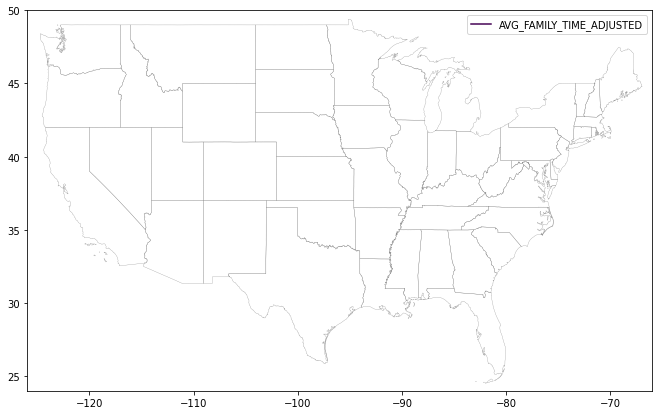

In [27]:
states = geopandas.read_file('/Users/jericho/Documents/csi/csi-research/Data/clean/state/state_metadata/state_metadata.shp')
temp_data = copy.deepcopy(div_map_data)
temp_data = temp_data[['AVG_FAMILY_TIME_ADJUSTED', 'geometry']]
ax = states.boundary.plot(figsize=(20,7),edgecolor='grey',linewidth=0.25)
plt.xlim((-126,-66))
plt.ylim((24,50))
temp_data.plot(ax=ax,column='AVG_FAMILY_TIME_ADJUSTED',legend=True,cmap='viridis')
plt.show()

In [28]:
def knn_adj_matrix(adj,k):
    adj_matrix = []
    if type(adj) != type([]):
        adj = adj.values.tolist()
    for row in adj:
        threshold = sorted(list(row))[k-1]
        new_row = [1 if i <= threshold else 0 for i in row]
        adj_matrix.append(new_row)
    return adj_matrix

adj_matrix = knn_adj_matrix(cbsa_dists_filtered,5)
for i in range(len(adj_matrix)):
    if sum(adj_matrix[i]) > 5:
        print(i,sum(adj_matrix[i]))

In [29]:
# Use this to select index start point for next code block
#cols = cbsa_summary_df.columns.tolist()
#for i in range(len(cols)): print(i,cols[i])

In [30]:
cols = cbsa_summary_df.columns.tolist()
cbsa_feature_df = copy.deepcopy(cbsa_summary_df)
cbsa_feature_df = cbsa_feature_df[['GEO']+cols[14:]]


for feature in cols[14:]:
    for k in range(1,16):
        #cbsa_feature_df = kth_n_dist(cbsa_feature_df,cbsa_dists_filtered,k)
        adj_matrix = knn_adj_matrix(cbsa_dists_filtered,k)
        vector = cbsa_feature_df[feature].tolist()
        z_vector = z_score_array(vector)
        I, EI, Var, Z = calc_local_i(z_vector, adj_matrix)
        GiD,Wi,EGi,VarG,Z_gi = calc_gi_kth_updated(vector,adj_matrix)
        #print(k,sum(I),sum(GiD))
        string = 'K='+str(k)+'_'+feature
        temp_df = pd.DataFrame(data={string+'_Local_I_Score':I, string+'_Local_I_Z_Score':Z, string+'_Gi_Score':GiD, string+'_Gi_Z_Score':Z_gi})
        cbsa_feature_df = pd.concat([cbsa_feature_df, temp_df],axis=1)


In [31]:
'''features = ['AVG_NHFAMILY_TIME', 'AVG_NHFAMILY_IX','AVG_NHFAMILY_SOCIAL_TIME_RATIO','AVG_TRIP_TO_NHFAMILY_DUR','RESP_COUNT']
for col in cbsa_feature_df.columns:
    if col in features:
        print(col)
        x = cbsa_feature_df[col]
        y = cbsa_feature_df['K=8_'+col+'_Gi_Z_Score']
        plt.scatter(x,y)
        plt.title(col+' G_i Z')
        plt.show()
        y = cbsa_feature_df['K=8_'+col+'_Local_I_Z_Score']
        plt.scatter(x,y)
        plt.title(col+' Local I Z')
        plt.show()
        plt.hist(y)
        plt.show()'''
pass

In [33]:
gdf = geopandas.read_file('/Users/jericho/Documents/csi/csi-research/Data/clean/cbsa/cbsa_metadata/cbsa_metadata.shp')
gdf['GEOID'] = [int(i) for i in gdf['GEOID']]
gdf.head(3)

GEOID          NAME        ALAND  SQRT_ALAND     POP  LOG_POP  POP_DEN  \
0  10100  Aberdeen, SD  2838.994894   53.282219   42824     4.63    15.08   
1  10140  Aberdeen, WA  1901.463095   43.605769   72779     4.86    38.28   
2  10180   Abilene, TX  2743.498528   52.378417  170669     5.23    62.21   

   L_POPDEN   POP15  L_POP15DEN  LOG_POP15  POP15_DEN  \
0  1.178401   34406    1.083503       4.54      12.12   
1  1.582972   60442    1.502291       4.78      31.79   
2  1.793860  136682    1.697404       5.14      49.82   

                                            geometry  
0  POLYGON ((-99.70770 45.59339, -98.72500 45.591...  
1  POLYGON ((-124.35364 47.53354, -124.04650 47.5...  
2  POLYGON ((-100.14861 32.40494, -100.14654 32.5...

(25.0, 50.0)

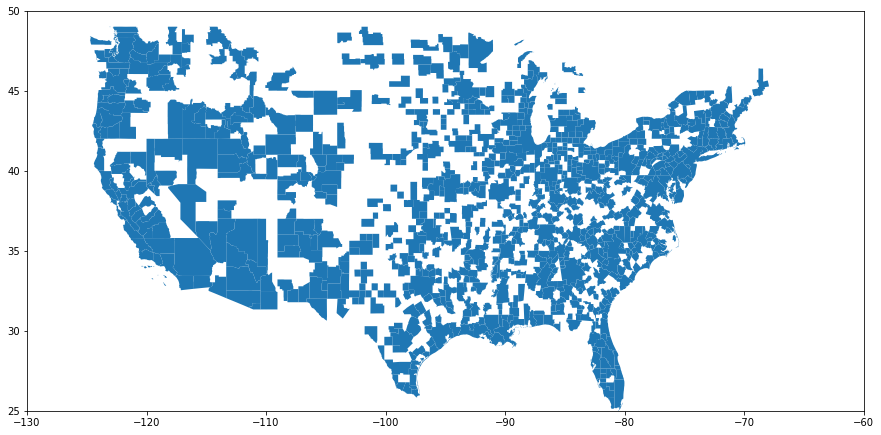

In [34]:
gdf.plot(figsize=(15,10))
plt.xlim((-130,-60))
plt.ylim((25,50))

In [35]:
geoid = gdf['GEOID'].tolist()
geo = cbsa_feature_df['GEO'].tolist()
print(type(geoid[0]),type(geo[0]))

<class 'int'> <class 'int'>


In [36]:
cbsa_feature_df.columns

Index(['GEO', 'AVG_FAMILY_TIME', 'AVG_FAMILY_TIME_UNWEIGHTED',
       'AVG_FAMILY_TIME_ADJUSTED', 'AVG_FAMILY_NONWORK_TIME',
       'AVG_FAMILY_NONWORK_TIME_UNWEIGHTED',
       'AVG_FAMILY_NONWORK_TIME_ADJUSTED', 'AVG_FAMILY_IX',
       'AVG_FAMILY_IX_UNWEIGHTED', 'AVG_FAMILY_IX_ADJUSTED',
       ...
       'K=13_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Gi_Score',
       'K=13_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Gi_Z_Score',
       'K=14_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Local_I_Score',
       'K=14_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Local_I_Z_Score',
       'K=14_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Gi_Score',
       'K=14_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Gi_Z_Score',
       'K=15_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Local_I_Score',
       'K=15_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Local_I_Z_Score',
       'K=15_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Gi_Score',
       'K=15_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Gi_Z_Score'],
      dtype='object', length=3295)

In [37]:
gdf_data = copy.deepcopy(gdf[gdf['GEOID'].isin(cbsa_feature_df['GEO'].tolist())])
print(gdf_data.shape)
print(gdf_data['GEOID'].tolist() == cbsa_feature_df['GEO'].tolist())

states = geopandas.read_file('/Users/jericho/Documents/csi/csi-research/Data/clean/state/state_metadata/state_metadata.shp')

skip = True

for col in cbsa_feature_df.columns.tolist():#[0:8]:
    if 'K=8' in col and skip == False:
        if 'Gi_Z' in col:
            print(col)
            ax = states.boundary.plot(figsize=(20,7),edgecolor='grey',linewidth=0.25)
            plt.xlim((-126,-66))
            plt.ylim((24,50))
            gdf_data['Data'] = cbsa_feature_df[col]
            gdf_data.plot(ax=ax,column='Data',legend=True,cmap='Reds')
            plt.title(col)
            plt.show()
        elif 'Local_I_Z' in col:
            print(col)
            ax = states.boundary.plot(figsize=(20,7),edgecolor='grey',linewidth=0.25)
            gdf_data['Data'] = cbsa_feature_df[col]
            gdf_data.plot(ax=ax,column='Data',legend=True,cmap='Blues')
            plt.xlim((-126,-66))
            plt.ylim((24,50))
            plt.title(col)
            plt.show()

(258, 13)
True


In [46]:
cbsa_regions_trunc

GEO     REGION            DIVISION
0     10100    Midwest  West North Central
2     10140       West             Pacific
3     10180      South  West South Central
6     10220      South  West South Central
7     10260          0                   0
...     ...        ...                 ...
1876  49660  Northeast     Middle Atlantic
1877  49700       West             Pacific
1879  49740       West            Mountain
1880  49780    Midwest  East North Central
1881  49820      South  West South Central

[957 rows x 3 columns]

In [47]:
cbsa_region_feature_df = pd.merge(cbsa_feature_df,cbsa_regions_trunc,how='left',left_on='GEO',right_on='GEO')
cbsa_region_feature_df

GEO  AVG_FAMILY_TIME  AVG_FAMILY_TIME_UNWEIGHTED  \
0    10180           262.64                      318.66   
1    10420           391.52                      356.43   
2    10580           393.80                      361.05   
3    10740           311.92                      328.57   
4    10900           286.56                      332.69   
..     ...              ...                         ...   
268  49340           303.54                      328.43   
269  49620           365.45                      409.30   
270  49660           338.68                      342.07   
271  49660           338.68                      342.07   
272  49740           470.22                      447.46   

     AVG_FAMILY_TIME_ADJUSTED  AVG_FAMILY_NONWORK_TIME  \
0                      248.78                   222.20   
1                      423.10                   344.66   
2                      396.96                   360.53   
3                      352.41                   279.17   
4                      360.56                   251.52   
..                        ...                      ...   
268                    307.22                   270.13   
269                    355.18                   333.98   
270                    361.65                   298.67   
271                    361.65                   298.67   
272                    558.00                   427.14   

     AVG_FAMILY_NONWORK_TIME_UNWEIGHTED  AVG_FAMILY_NONWORK_TIME_ADJUSTED  \
0                                273.86                            214.39   
1                                311.95                            367.50   
2                                327.73                            359.07   
3                                296.42                            319.09   
4                                291.60                            318.77   
..                                  ...                               ...   
268                              293.86                            273.79   
269                              372.68                            324.19   
270                              305.60                            322.09   
271                              305.60                            322.09   
272                              408.95                            511.92   

     AVG_FAMILY_IX  AVG_FAMILY_IX_UNWEIGHTED  AVG_FAMILY_IX_ADJUSTED  ...  \
0             0.79                      0.74                    0.62  ...   
1             0.79                      0.70                    0.75  ...   
2             0.84                      0.79                    0.81  ...   
3             0.78                      0.74                    0.78  ...   
4             0.83                      0.80                    0.84  ...   
..             ...                       ...                     ...  ...   
268           0.86                      0.83                    0.86  ...   
269           0.95                      0.88                    0.82  ...   
270           0.84                      0.79                    0.82  ...   
271           0.84                      0.79                    0.82  ...   
272           0.83                      0.81                    0.92  ...   

     K=14_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Local_I_Score  \
0                                            -4.485340      
1                                            -0.613484      
2                                            -3.696051      
3                                             1.338199      
4                                            -0.431212      
..                                                 ...      
268                                           2.053008      
269                                         -14.120123      
270                                          -0.961891      
271                                          -0.961891      
272                                          -1.236778      

     K=14_AVG_TRIP

In [51]:
cbsa_region_feature_df = pd.merge(cbsa_feature_df,cbsa_regions_trunc,how='left',left_on='GEO',right_on='GEO')
cbsa_region_feature_df = cbsa_region_feature_df.drop_duplicates()
print(cbsa_region_feature_df.shape)
cbsa_region_feature_df.head(10)

(273, 3297)


GEO  AVG_FAMILY_TIME  AVG_FAMILY_TIME_UNWEIGHTED  \
0  10180           262.64                      318.66   
1  10420           391.52                      356.43   
2  10580           393.80                      361.05   
3  10740           311.92                      328.57   
4  10900           286.56                      332.69   
5  11100           315.14                      291.79   
6  11460           315.55                      322.19   
7  11540           305.72                      371.21   
8  11700           313.35                      307.98   
9  12020           239.06                      206.35   

   AVG_FAMILY_TIME_ADJUSTED  AVG_FAMILY_NONWORK_TIME  \
0                    248.78                   222.20   
1                    423.10                   344.66   
2                    396.96                   360.53   
3                    352.41                   279.17   
4                    360.56                   251.52   
5                    306.28                   283.85   
6                    295.99                   276.80   
7                    370.28                   263.14   
8                    310.26                   277.99   
9                    303.74                   213.40   

   AVG_FAMILY_NONWORK_TIME_UNWEIGHTED  AVG_FAMILY_NONWORK_TIME_ADJUSTED  \
0                              273.86                            214.39   
1                              311.95                            367.50   
2                              327.73                            359.07   
3                              296.42                            319.09   
4                              291.60                            318.77   
5                              259.11                            266.58   
6                              282.59                            259.48   
7                              322.24                            318.87   
8                              275.17                            274.68   
9                              180.58                            254.69   

   AVG_FAMILY_IX  AVG_FAMILY_IX_UNWEIGHTED  AVG_FAMILY_IX_ADJUSTED  ...  \
0           0.79                      0.74                    0.62  ...   
1           0.79                      0.70                    0.75  ...   
2           0.84                      0.79                    0.81  ...   
3           0.78                      0.74                    0.78  ...   
4           0.83                      0.80                    0.84  ...   
5           0.80                      0.71                    0.80  ...   
6           0.83                      0.78                    0.79  ...   
7           0.85                      0.86                    0.95  ...   
8           0.78                      0.79                    0.81  ...   
9           0.75                      0.65                    0.74  ...   

   K=14_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Local_I_Score  \
0                                          -4.485340      
1                                          -0.613484      
2                                          -3.696051      
3                                           1.338199      
4                                          -0.431212      
5                                          -1.977359      
6                                           0.888085      
7                                           3.293744      
8                                          -3.316507      
9                                          -2.299313      

   K=14_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Local_I_Z_Score  \
0                                          -1.213560        
1                                          -0.153106        
2                                          -0.997384        
3                                           0.381436        
4                                          -0.103184        
5                                          -0.526655        
6                              

In [ ]:
features = ['GEO','CBSA Code', 'Region', 'Sub Region']
for i in cbsa_region_feature_df.columns:
    if 'K=8' in i and 'Z' in i:
        features.append(i)

cbsa_region_feature_df = cbsa_region_feature_df[features]
cbsa_region_feature_df.head(3)

GEO  CBSA Code     Region          Sub Region  \
0  10180      10180      South  West South Central   
3  10420      10420    Midwest  East North Central   
5  10580      10580  Northeast     Middle Atlantic   

   K=8_AVG_FAMILY_TIME_Local_I_Z_Score  K=8_AVG_FAMILY_TIME_Gi_Z_Score  \
0                            -2.931091                        2.201895   
3                            -0.686811                       -0.633134   
5                            -0.622574                       -0.551153   

   K=8_AVG_FAMILY_TIME_UNWEIGHTED_Local_I_Z_Score  \
0                                       -0.546016   
3                                       -0.337867   
5                                       -0.234117   

   K=8_AVG_FAMILY_TIME_UNWEIGHTED_Gi_Z_Score  \
0                                   1.085568   
3                                  -1.193688   
5                                  -0.625054   

   K=8_AVG_FAMILY_TIME_ADJUSTED_Local_I_Z_Score  \
0                                     -1.904962   
3                                     -2.060453   
5                                     -1.327774   

   K=8_AVG_FAMILY_TIME_ADJUSTED_Gi_Z_Score  ...  \
0                                 0.992625  ...   
3                                -1.373903  ...   
5                                -1.348898  ...   

   K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_UNWEIGHTED_Local_I_Z_Score  \
0                                          -1.151477               
3                                          -0.433225               
5                                           0.261425               

   K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_UNWEIGHTED_Gi_Z_Score  \
0                                           1.476313          
3                                           0.558888          
5                                           0.742679          

   K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_ADJUSTED_Local_I_Z_Score  \
0                                          -0.662166             
3                                           0.040130             
5                                           0.035116             

   K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_ADJUSTED_Gi_Z_Score  \
0                                           0.612113        
3                                           0.394434        
5                                           0.120906        

   K=8_AVG_TRIP_TO_NHFAMILY_DUR_Local_I_Z_Score  \
0                                     -0.999868   
3                                     -0.232765   
5                                     -0.645888   

   K=8_AVG_TRIP_TO_NHFAMILY_DUR_Gi_Z_Score  \
0                                 0.986174   
3                                -0.418820   
5                                -0.559791   

   K=8_AVG_TRIP_TO_NHFAMILY_DUR_UNWEIGHTED_Local_I_Z_Score  \
0                                          -1.659014         
3                                           0.044538         
5                                          -0.301335         

   K=8_AVG_TRIP_TO_NHFAMILY_DUR_UNWEIGHTED_Gi_Z_Score  \
0                                           1.313685    
3                                           0.412982    
5                                          -0.120064    

   K=8_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Local_I_Z_Score  \
0                                          -1.787611       
3                                           0.081337       
5                                          -1.624555       

   K=8_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Gi_Z_Score  
0                                          1.404692  
3                                          0.200074  
5                                         -0.636708  

[3 rows x 112 columns]

In [ ]:
def shiftedColorMap(cmap, start=0.0, midpoint=0.5, stop=1, name='shiftedcmap'):
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import AxesGrid
    '''
    Author of function: https://stackoverflow.com/users/1552748/paul-h
    Source webpage: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


In [ ]:
'''import matplotlib

region_file = '/Users/jericho/Documents/csi/family-geog/data/clean/region/region_metadata/region_metadata.shp'
division_file = '/Users/jericho/Documents/csi/family-geog/data/clean/division/division_metadata/division_metadata.shp'
plots_dir = '/Users/jericho/Documents/csi/csi-research/plots/'

region_gdf = geopandas.read_file(region_file)
region_gdf['GEOID'] = [int(i) for i in region_gdf['GEOID']]

division_gdf = geopandas.read_file(division_file)
division_gdf['GEOID'] = [int(i) for i in division_gdf['GEOID']]


region_feature_df = cbsa_region_feature_df.groupby('Region').mean()
region_feature_df = region_feature_df.reset_index()
division_feature_df = cbsa_region_feature_df.groupby('Sub Region').mean()
division_feature_df = division_feature_df.reset_index()

#features = ['K=8_AVG_NHFAMILY_TIME_Local_I_Z_Score',
#            'K=8_AVG_NHFAMILY_TIME_Gi_Z_Score',
#            'K=8_AVG_NHFAMILY_IX_Local_I_Z_Score', 
#            'K=8_AVG_NHFAMILY_IX_Gi_Z_Score',
#            'K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_Local_I_Z_Score',
#            'K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_Gi_Z_Score',
#            'K=8_AVG_TRIP_TO_NHFAMILY_DUR_Local_I_Z_Score',
#            'K=8_AVG_TRIP_TO_NHFAMILY_DUR_Gi_Z_Score']

temp_features = ['K=8_'+i for i in cols[14:]]
print(temp_features)
features = []
for i in temp_features:
    features.append(i+'_Gi_Z_Score')
    features.append(i+'_Local_I_Z_Score')

division_gdf = pd.merge(division_gdf, division_feature_df, how='inner', left_on='NAME', right_on='Sub Region').drop_duplicates()
region_gdf = pd.merge(region_gdf, region_feature_df, how='inner', left_on='NAME', right_on='Region').drop_duplicates()

for f in features:
    print(f)
    mi,ma = division_gdf[f].min(), division_gdf[f].max()
    mid = 1 - (ma / (ma +abs(mi)))
    new_cmap = shiftedColorMap(matplotlib.cm.Blues, midpoint=mid, name='shiftedcmap')
    ax = states.boundary.plot(figsize=(20,7),edgecolor='grey',linewidth=0.25)
    plt.xlim((-126,-66))
    plt.ylim((24,50))
    division_gdf.plot(ax=ax,column=f,legend=True,cmap='shiftedcmap')
    plt.title(f)
    #plt.savefig(plots_dir+f+'_division.png')
    plt.show()

for f in features:
    print(f)
    mi,ma = region_gdf[f].min(), region_gdf[f].max()
    mid = 1 - (ma / (ma +abs(mi)))
    new_cmap = shiftedColorMap(matplotlib.cm.Blues, midpoint=mid, name='shiftedcmap')
    ax = states.boundary.plot(figsize=(20,7),edgecolor='grey',linewidth=0.25)
    plt.xlim((-126,-66))
    plt.ylim((24,50))
    region_gdf.plot(ax=ax,column=f,legend=True,cmap='shiftedcmap')
    #plt.savefig(plots_dir+f+'_region.png')
    plt.show()'''
pass

In [ ]:
# Feature extraction
feature_list = cols[14:]
feature_list = [i for i in feature_list if 'UNWEIGHTED' not in i]
feature_list = [i for i in feature_list if 'ADJUSTED' not in i]
feature_list

['AVG_FAMILY_TIME',
 'AVG_FAMILY_NONWORK_TIME',
 'AVG_FAMILY_IX',
 'AVG_HHFAMILY_TIME',
 'AVG_HHFAMILY_NONWORK_TIME',
 'AVG_HHFAMILY_IX',
 'AVG_NHFAMILY_TIME',
 'AVG_NHFAMILY_NONWORK_TIME',
 'AVG_NHFAMILY_IX',
 'AVG_FRIEND_TIME',
 'AVG_FRIEND_NONWORK_TIME',
 'AVG_FRIEND_IX',
 'AVG_CCC_TIME',
 'AVG_CCC_NONWORK_TIME',
 'AVG_CCC_IX',
 'AVG_NHSOCIAL_TIME',
 'AVG_NHFAMILY_SOCIAL_TIME_RATIO',
 'AVG_TRIP_TO_NHFAMILY_DUR']

In [ ]:
def axes_position(string):
    if 'UNWEIGHTED' in f:
        y = 0
    elif 'ADJUSTED' in f:
        y = 2
    else:
        y = 1
    if 'Gi_Z' in f:
        x = 0
    else:
        x = 1
    return x,y

In [ ]:
region_gdf


GEOID       NAME         ALAND   SQRT_ALAND        POP  LOG_POP  POP_DEN  \
0      1  Northeast  1.619132e+05   402.384419   56033139     7.75   346.07   
1      2    Midwest  7.505776e+05   866.358838   68108086     7.83    90.74   
2      3      South  8.686583e+05   932.018411  123408246     8.09   142.07   
3      4       West  1.751869e+06  1323.581959   77148324     7.89    44.04   

   L_POPDEN     POP15  L_POP15DEN  ...  \
0  2.539164  46411649    2.457352  ...   
1  1.957799  55284001    1.867232  ...   
2  2.152502  99822774    2.060396  ...   
3  1.643847  62326946    1.551206  ...   

   K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_UNWEIGHTED_Local_I_Z_Score  \
0                                           0.059061               
1                                           0.134096               
2                                          -0.079985               
3                                          -0.034225               

   K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_UNWEIGHTED_Gi_Z_Score  \
0                                          -0.372937          
1                                           0.016255          
2                                           0.371313          
3                                          -0.014780          

  K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_ADJUSTED_Local_I_Z_Score  \
0                                           0.055509            
1                                           0.146391            
2                                          -0.004895            
3                                           0.121395            

  K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_ADJUSTED_Gi_Z_Score  \
0                                          -0.172691       
1                                           0.035122       
2                                           0.105719       
3                                           0.123391       

   K=8_AVG_TRIP_TO_NHFAMILY_DUR_Local_I_Z_Score  \
0                                     -0.180015   
1                                     -0.109562   
2                                     -0.039841   
3                                      0.111734   

   K=8_AVG_TRIP_TO_NHFAMILY_DUR_Gi_Z_Score  \
0                                 0.366334   
1                                -0.118590   
2                                 0.266735   
3                                -0.147380   

   K=8_AVG_TRIP_TO_NHFAMILY_DUR_UNWEIGHTED_Local_I_Z_Score  \
0                                          -0.222510         
1                                          -0.199332         
2                                          -0.055228         
3                                           0.039480         

   K=8_AVG_TRIP_TO_NHFAMILY_DUR_UNWEIGHTED_Gi_Z_Score  \
0                                           0.232842    
1                                           0.010580    
2                                           0.236397    
3                                          -0.025290    

   K=8_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Local_I_Z_Score  \
0                                          -0.147963       
1                                          -0.166693       
2                                          -0.202014       
3                                           0.008577       

   K=8_AVG_TRIP_TO_NHFAMILY_DUR_ADJUSTED_Gi_Z_Score  
0                                          0.035572  
1                                         -0.205159  
2                                          0.264480  
3                                          0.035317  

[4 rows x 124 columns]

$\langle t \rangle_{pop}$

-0.6861947178533052 0.08383626703866533


/var/folders/qv/9w3wskgd1pj1k5ffzq67k54c0000gn/T/ipykernel_39239/556427852.py:43: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(im, cax=cax, cmap='Blues')
/var/folders/qv/9w3wskgd1pj1k5ffzq67k54c0000gn/T/ipykernel_39239/556427852.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


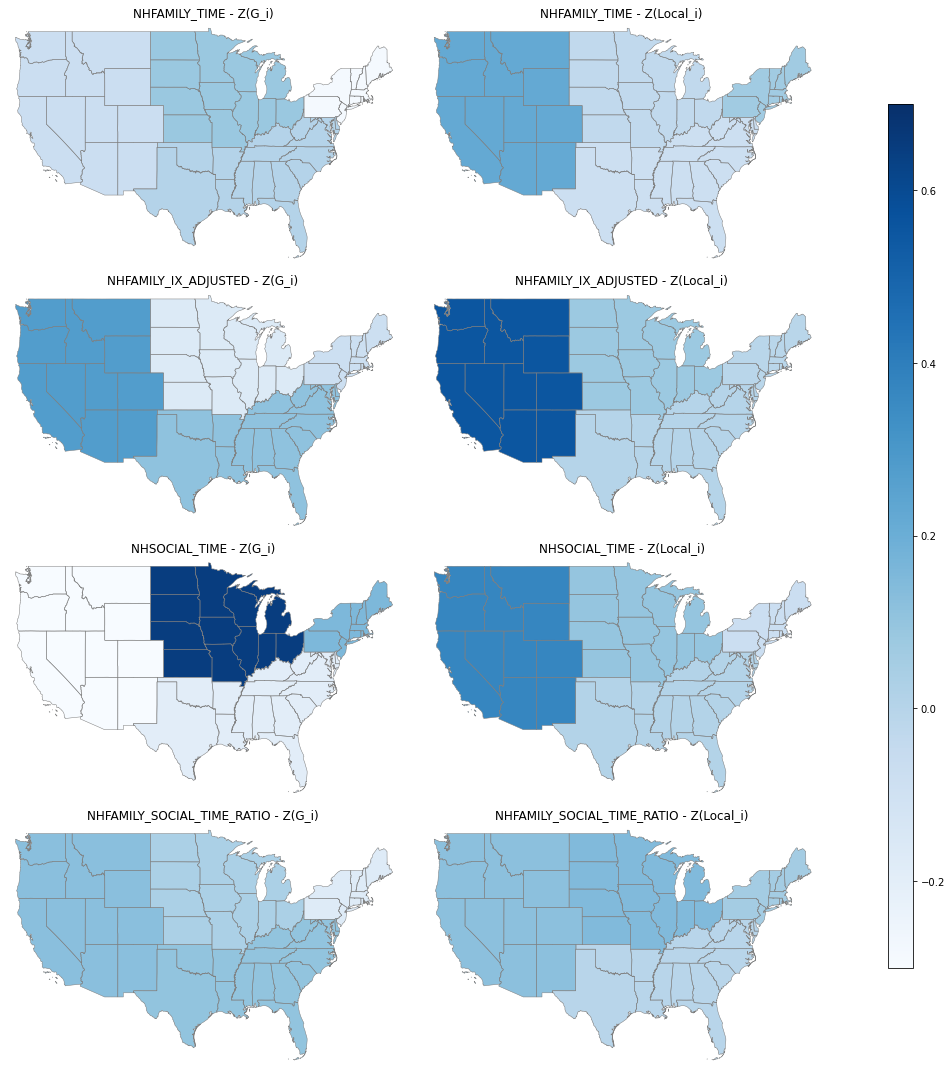

In [ ]:
temp_features = ['K=8_AVG_NHFAMILY_TIME_ADJUSTED_Gi_Z_Score',
    'K=8_AVG_NHFAMILY_TIME_ADJUSTED_Local_I_Z_Score',
    'K=8_AVG_NHFAMILY_IX_ADJUSTED_Gi_Z_Score',
    'K=8_AVG_NHFAMILY_IX_ADJUSTED_Local_I_Z_Score',
    'K=8_AVG_NHSOCIAL_TIME_ADJUSTED_Gi_Z_Score',
    'K=8_AVG_NHSOCIAL_TIME_ADJUSTED_Local_I_Z_Score',
    'K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_ADJUSTED_Gi_Z_Score',
    'K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_ADJUSTED_Local_I_Z_Score']

titles = ['NHFAMILY_TIME - Z(G_i)' ,
          'NHFAMILY_TIME - Z(Local_i)',
          'NHFAMILY_IX_ADJUSTED - Z(G_i)' ,
          'NHFAMILY_IX_ADJUSTED - Z(Local_i)',
          'NHSOCIAL_TIME - Z(G_i)' ,
          'NHSOCIAL_TIME - Z(Local_i)',
          'NHFAMILY_SOCIAL_TIME_RATIO - Z(G_i)' ,
          'NHFAMILY_SOCIAL_TIME_RATIO - Z(Local_i)', ]

region_gdf_subset = region_gdf[temp_features]
mi,ma = region_gdf_subset.min().min(), region_gdf_subset.max().min()
print(mi,ma)
mid = 1 - (ma / (ma +abs(mi)))
custom_cmap = shiftedColorMap(matplotlib.cm.Blues, midpoint=mid, name='custom_cmap')

pos = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1]]
pos = [[0,0],[1,0],[0,1],[1,1],[0,2],[1,2],[0,3],[1,3]]

fig, axes = plt.subplots(figsize=(12,15),sharex=True, sharey=True, ncols=2,nrows=4)
for i in range(len(temp_features)):
    f = temp_features[i]
    y,x = pos[i]

    states.boundary.plot(ax=axes[x,y],edgecolor='grey',linewidth=0.5)
    axes[x,y].set_xlim((-126,-66))
    axes[x,y].set_ylim((24,50))
    region_gdf.plot(ax=axes[x,y],column=f,legend=False, cmap='Blues', vmin=-0.3, vmax=0.7)
    axes[x,y].set_title(titles[i])
    axes[x,y].axis('off')
    #plt.title(f)

im = plt.gca().get_children()[1]
cax = fig.add_axes([1.05,0.1,0.03,0.8]) 
fig.colorbar(im, cax=cax, cmap='Blues')

fig.tight_layout()
plt.savefig(plots_dir+feature+'_division.png')
plt.show()

In [ ]:
'''temp_features =  ['K=8_AVG_NHFAMILY_TIME_Gi_Z_Score', 'K=8_AVG_NHFAMILY_TIME_Local_I_Z_Score', 'K=8_AVG_NHFAMILY_TIME_UNWEIGHTED_Gi_Z_Score',
                  'K=8_AVG_NHFAMILY_TIME_UNWEIGHTED_Local_I_Z_Score', 'K=8_AVG_NHFAMILY_TIME_ADJUSTED_Gi_Z_Score', 'K=8_AVG_NHFAMILY_TIME_ADJUSTED_Local_I_Z_Score']

prepend = 'K=8_'
append1 = ['_UNWEIGHTED','','_ADJUSTED']
append2 = ['_Gi_Z_Score', '_Local_I_Z_Score']

for feature in feature_list:
    temp_features = []
    for i in append1:
        for j in append2:
            temp_features.append(prepend+feature+i+j)

    fig, axes = plt.subplots(figsize=(12,8),ncols=2,nrows=3)
    for f in temp_features:
        y,x = axes_position(f)
        mi,ma = region_gdf[f].min(), region_gdf[f].max()
        mid = 1 - (ma / (ma +abs(mi)))
        try:
            new_cmap = shiftedColorMap(matplotlib.cm.Blues, midpoint=mid, name=f+'shiftedcmap')
        except:
            pass
        states.boundary.plot(ax=axes[x,y], figsize=(20,7),edgecolor='grey',linewidth=0.25)
        axes[x,y].set_xlim((-126,-66))
        axes[x,y].set_ylim((24,50))
        region_gdf.plot(ax=axes[x,y],column=f,legend=True,cmap=f+'shiftedcmap')
        axes[x,y].set_title(f)
        #plt.title(f)
    
    fig.tight_layout()
    plt.savefig(plots_dir+feature+'_division.png')
    plt.show()'''
pass

In [44]:
division_gdf

GEOID                NAME          ALAND  SQRT_ALAND       POP  LOG_POP  \
0      1         New England   62693.168569  250.386039  14790787     7.17   
1      2     Middle Atlantic   99220.052356  314.992146  41242352     7.62   
2      3  East North Central  242971.961792  492.921862  46847712     7.67   
3      4  West North Central  507605.674144  712.464507  21260374     7.33   
4      5      South Atlantic  265299.077688  515.071915  64531712     7.81   
5      6  East South Central  178294.181085  422.248956  19019076     7.28   
6      7  West South Central  425065.059608  651.970137  39857458     7.60   
7      8            Mountain  856119.966977  925.267511  24171755     7.38   
8      9             Pacific  895749.235588  946.440297  52976569     7.72   

   POP_DEN  L_POPDEN     POP15  L_POP15DEN  LOG_POP15  POP15_DEN  \
0   235.92  2.372765  12383050    2.295611       7.09     197.52   
1   415.67  2.618749  34028599    2.535243       7.53     342.96   
2   192.81  2.285130  38173322    2.196204       7.58     157.11   
3    41.88  1.622007  17110679    1.527759       7.23      33.71   
4   243.24  2.386035  52944245    2.300073       7.72     199.56   
5   106.67  2.028042  15439456    1.937518       7.19      86.60   
6    93.77  1.972064  31439073    1.868997       7.50      73.96   
7    28.23  1.450711  19351138    1.354108       7.29      22.60   
8    59.14  1.771881  42975808    1.681060       7.63      47.98   

                                            geometry  
0  MULTIPOLYGON (((-68.37659 44.11376, -68.37538 ...  
1  MULTIPOLYGON (((-72.03799 41.25351, -72.02944 ...  
2  MULTIPOLYGON (((-82.73571 41.60336, -82.71880 ...  
3  POLYGON ((-104.05770 44.99743, -104.05021 44.9...  
4  MULTIPOLYGON (((-75.57080 39.62677, -75.55945 ...  
5  MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ...  
6  MULTIPOLYGON (((-88.88145 30.05320, -88.87048 ...  
7  POLYGON ((-120.00574 39.22866, -120.00526 39.2...  
8  MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...

AttributeError: 'Line2D' object has no property 'vmin'

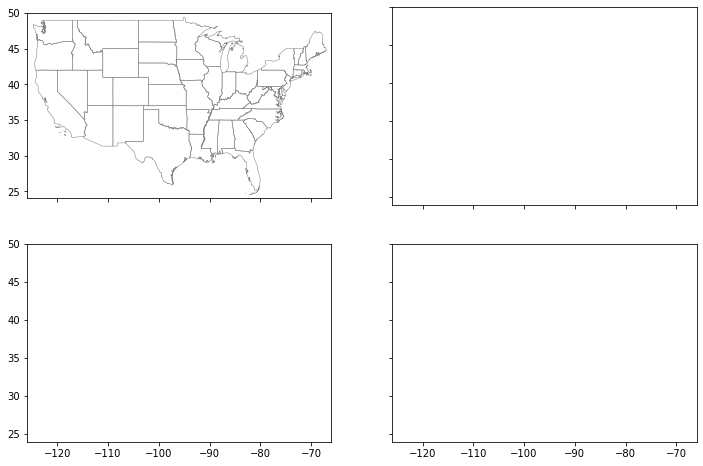

In [41]:
temp_features = [    'K=8_AVG_NHFAMILY_IX_ADJUSTED_Gi_Z_Score',
    'K=8_AVG_NHFAMILY_IX_ADJUSTED_Local_I_Z_Score', 
    'K=8_AVG_NHFAMILY_TIME_ADJUSTED_Gi_Z_Score',
    'K=8_AVG_NHFAMILY_TIME_ADJUSTED_Local_I_Z_Score',]
#,
    #'K=8_AVG_NHSOCIAL_TIME_ADJUSTED_Gi_Z_Score',
    #'K=8_AVG_NHSOCIAL_TIME_ADJUSTED_Local_I_Z_Score',
    #'K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_ADJUSTED_Gi_Z_Score',
    #'K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_ADJUSTED_Local_I_Z_Score']

titles = ['Non-coresident Family Availability - $z(G_i)$' ,
          'Non-coresident Family Availability - $z(I_i)$'
          'Non-coresident Family Time - $z(G_i)$',
          'Non-coresident Family Time - $z(I_i)$',]
        
          #'Social Time - $z(G_i)$' ,
          #'Social Time - $z(I_i)$',
          #'Non-coresident Portion of Social Time - $z(G_i)$' ,
          #'Non-coresident Portion of Social Time - $z(I_i)$']

#division_gdf_subset = division_gdf[temp_features]
#mi,ma = division_gdf_subset.min().min(), division_gdf_subset.max().min()
#print(mi,ma)
#mid = 1 - (ma / (ma +abs(mi)))
#custom_cmap = shiftedColorMap(matplotlib.cm.RdYlGn, midpoint=mid, name='custom_cmap')

pos = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1]]
pos = [[0,0],[1,0],[0,1],[1,1],[0,2],[1,2],[0,3],[1,3]]

fig, axes = plt.subplots(figsize=(12,8),sharex=True, sharey=True, ncols=2,nrows=2)
for i in range(len(temp_features)):
    f = temp_features[i]
    y,x = pos[i]

    states.boundary.plot(ax=axes[x,y],edgecolor='grey',linewidth=0.5)
    axes[x,y].set_xlim((-126,-66))
    axes[x,y].set_ylim((24,50))
    division_gdf.plot(ax=axes[x,y],column=f,legend=False, cmap='RdYlGn', vmin=-1, vmax=1)
    #division_gdf.plot(ax=axes[x,y],column=f,legend=False, cmap='inferno', vmin=-1, vmax=1)
    axes[x,y].set_title(titles[i])
    axes[x,y].axis('off')
    #plt.title(f)

im = plt.gca().get_children()[1]
cax = fig.add_axes([1.05,0.1,0.03,0.8]) 
fig.colorbar(im, cax=cax, cmap='RdYlGn')

fig.tight_layout()
plt.savefig(plots_dir+feature+'_division.png')
plt.show()

['K=8_AVG_NHSOCIAL_TIME_ADJUSTED_Gi_Z_Score', 'K=8_AVG_NHFAMILY_TIME_ADJUSTED_Gi_Z_Score', 'K=8_AVG_NHFAMILY_IX_ADJUSTED_Gi_Z_Score', 'K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_ADJUSTED_Gi_Z_Score']
['K=8_AVG_NHSOCIAL_TIME_ADJUSTED_Local_I_Z_Score', 'K=8_AVG_NHFAMILY_TIME_ADJUSTED_Local_I_Z_Score', 'K=8_AVG_NHFAMILY_IX_ADJUSTED_Local_I_Z_Score', 'K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_ADJUSTED_Local_I_Z_Score']


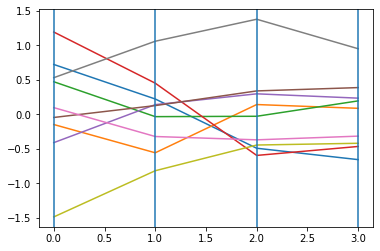

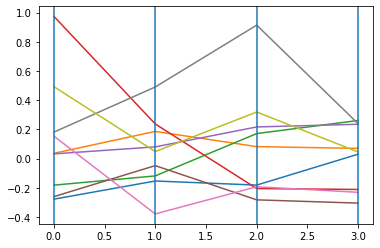

In [130]:
division_params = division_gdf[temp_features]
division_params.index = division_gdf['NAME']
division_dict = division_params.to_dict()

gi_features = [ 'K=8_AVG_NHSOCIAL_TIME_ADJUSTED_Gi_Z_Score','K=8_AVG_NHFAMILY_TIME_ADJUSTED_Gi_Z_Score', 'K=8_AVG_NHFAMILY_IX_ADJUSTED_Gi_Z_Score', 'K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_ADJUSTED_Gi_Z_Score', ]
li_features = ['K=8_AVG_NHSOCIAL_TIME_ADJUSTED_Local_I_Z_Score', 'K=8_AVG_NHFAMILY_TIME_ADJUSTED_Local_I_Z_Score', 'K=8_AVG_NHFAMILY_IX_ADJUSTED_Local_I_Z_Score', 'K=8_AVG_NHFAMILY_SOCIAL_TIME_RATIO_ADJUSTED_Local_I_Z_Score',  ]

division_names = division_gdf['NAME'].to_list()
variables = division_params.columns.tolist()

print(gi_features)
print(li_features)

for d in division_names:
    y = [division_dict[i][d] for i in gi_features]
    plt.plot(y,label=d)
#plt.legend()
for i in range(4):
    plt.axvline(x=i)

plt.show()

for d in division_names:
    y = [division_dict[i][d] for i in li_features]
    plt.plot(y,label=d)
for i in range(4):
    plt.axvline(x=i)

plt.show()


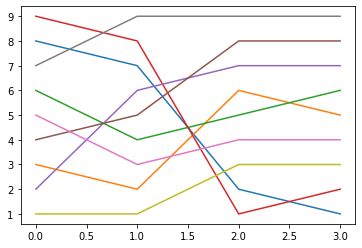

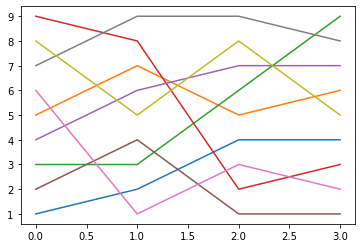

K=8_AVG_NHFAMILY_TIME_ADJUSTED_Gi_Z_Score  \
NAME                                                            
New England                                          0.222097   
Middle Atlantic                                     -0.556432   
East North Central                                  -0.033339   
West North Central                                   0.450987   
South Atlantic                                       0.140424   
East South Central                                   0.126656   
West South Central                                  -0.320900   
Mountain                                             1.057979   
Pacific                                             -0.816124   

                    K=8_AVG_NHFAMILY_TIME_ADJUSTED_Local_I_Z_Score  \
NAME                                                                 
New England                                              -0.154132   
Middle Atlantic                                           0.185810   
East North Central                                       -0.119292   
West North Central                                        0.236782   
South Atlantic                                            0.079819   
East South Central                                       -0.048751   
West South Central                                       -0.379794   
Mountain                                                  0.490363   
Pacific                                                   0.047689   

                    K=8_AVG_NHFAMILY_IX_ADJUSTED_Gi_Z_Score  \
NAME                                                          
New England                                       -0.490578   
Middle Atlantic                                    0.141799   
East North Central                                -0.028060   
West North Central                                -0.594551   
South Atlantic                                     0.296929   
East South Central                                 0.338958   
West South Central                                -0.369002   
Mountain                                           1.376312   
Pacific                                           -0.444153   

                    K=8_AVG_NHFAMILY_IX_ADJUSTED_Local_I_Z_Score  \
NAME                                                               
New England                                            -0.182144   
Middle Atlantic                                         0.081468   
East North Central                                      0.170923   
West North Central                                     -0.205782   
South Atlantic                                          0.216460   
East South Central                                     -0.283408   
West South Central                                     -0.193619   
Mountain                                                0.914277   
Pacific                                                 0.318863   

                    K=8_AVG_NHSOCIAL_TIME_ADJUSTED_Gi_Z_Score  \
NAME                                                            
New England                                          0.721953   
Middle Atlantic                                     -0.147354   
East North Central                                   0.471808   
West North Central                                   1.191222   
South Atlantic                                      -0.409598   
East South Central                                  -0.045296   
West South Central                                   0.097200   
Mountain                                             0.530374   
Pacific                                             -1.484568   

                    K=8_AVG_NHSOCIAL_TIME_ADJUSTED_Local_I_Z_Score  \
NAME                                                                 
New England                                              -0.278763   
Middle Atlantic                                           0.035473   
East North Central                                       -0.182607   
West North Central      

In [131]:
division_params = copy.deepcopy(division_gdf[temp_features])
division_params.index = division_gdf['NAME']
for col in division_params.columns:
    division_params[col+'_RANK'] = division_params[col].rank()

division_dict = division_params.to_dict()

for d in division_names:
    y = [division_dict[i+'_RANK'][d] for i in gi_features]
    plt.plot(y,label=d)
#plt.legend()
plt.show()

for d in division_names:
    y = [division_dict[i+'_RANK'][d] for i in li_features]
    plt.plot(y,label=d)
plt.show()

division_params

In [80]:
'''temp_features =  ['K=8_AVG_NHFAMILY_TIME_Gi_Z_Score', 'K=8_AVG_NHFAMILY_TIME_Local_I_Z_Score', 'K=8_AVG_NHFAMILY_TIME_UNWEIGHTED_Gi_Z_Score',
                  'K=8_AVG_NHFAMILY_TIME_UNWEIGHTED_Local_I_Z_Score', 'K=8_AVG_NHFAMILY_TIME_ADJUSTED_Gi_Z_Score', 'K=8_AVG_NHFAMILY_TIME_ADJUSTED_Local_I_Z_Score']

prepend = 'K=8_'
append1 = ['_UNWEIGHTED','','_ADJUSTED']
append2 = ['_Gi_Z_Score', '_Local_I_Z_Score']

for feature in feature_list:
    temp_features = []
    for i in append1:
        for j in append2:
            temp_features.append(prepend+feature+i+j)

    fig, axes = plt.subplots(figsize=(12,8),ncols=2,nrows=3)
    for f in temp_features:
        y,x = axes_position(f)
        mi,ma = division_gdf[f].min(), division_gdf[f].max()
        mid = 1 - (ma / (ma +abs(mi)))
        try:
            new_cmap = shiftedColorMap(matplotlib.cm.Blues, midpoint=mid, name=f+'shiftedcmap')
        except:
            pass
        states.boundary.plot(ax=axes[x,y], figsize=(20,7),edgecolor='grey',linewidth=0.25)
        axes[x,y].set_xlim((-126,-66))
        axes[x,y].set_ylim((24,50))
        division_gdf.plot(ax=axes[x,y],column=f,legend=True,cmap=f+'shiftedcmap')
        axes[x,y].set_title(f)
        #plt.title(f)
    
    fig.tight_layout()
    plt.savefig(plots_dir+feature+'_division.png')
    plt.show()'''
pass

In [ ]:
6//3


2